# CPE 595 Homework 4 - Sigmoid Function

## Question 1: Programming

### Step 1:  Data Acquisition and Visualization

In [33]:
import numpy as np
import struct
import gzip
import matplotlib.pyplot as plt

# reading IDX files
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [34]:
# Load the MNIST Dataset
# Define the file paths for the downloaded dataset
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

# Load the datasets using the read_idx function
train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)

# Print out the shapes of each dataset array
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


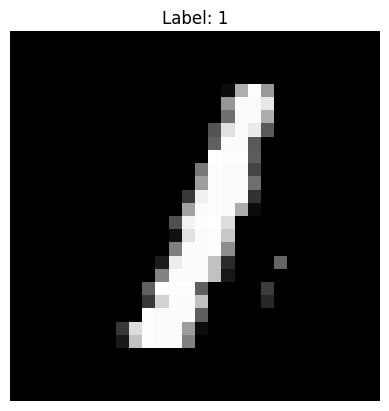

In [35]:
# Plot some sample images from the dataset

import random

# Choose a random index from the training data
random_index = random.randint(0, train_images.shape[0] - 1)

# Display the image using plt.imshow with a grayscale colormap
plt.imshow(train_images[random_index], cmap='gray')
plt.title("Label: {}".format(train_labels[random_index]))
plt.axis('off')  # Hide the axes
plt.show()


### Step 2:  Data Preprocesing

In [36]:
# Normalize the pixel values to be between 0 and 1
train_images_norm = train_images.astype(np.float32) / 255.0
test_images_norm = test_images.astype(np.float32) / 255.0

In [37]:
# Define the number of classes (digits 0-9, 10 classes)
num_classes = 10

# Convert the training and testing labels to one-hot encoded vectors
train_labels_onehot = np.eye(num_classes)[train_labels]
test_labels_onehot = np.eye(num_classes)[test_labels]


### Step 3:  Network Initialization

In [38]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def softmax(z):
    # Subtract the max for numerical stability
    z_exp = np.exp(z - np.max(z, axis=0, keepdims=True))
    return z_exp / np.sum(z_exp, axis=0, keepdims=True)

In [39]:
# Test initialization 
np.random.seed(695)

# Define the network architecture sizes
input_size = 784    # 28 x 28 images
hidden1_size = 128
hidden2_size = 64
output_size = 10   

# Initialize weights and biases using a uniform distribution
W1 = np.random.uniform(-0.1, 0.1, (hidden1_size, input_size))
b1 = np.random.uniform(-0.1, 0.1, (hidden1_size, 1))

W2 = np.random.uniform(-0.1, 0.1, (hidden2_size, hidden1_size))
b2 = np.random.uniform(-0.1, 0.1, (hidden2_size, 1))

W3 = np.random.uniform(-0.1, 0.1, (output_size, hidden2_size))
b3 = np.random.uniform(-0.1, 0.1, (output_size, 1))

# Print out the shapes to verify correct initialization
print("W1 shape:", W1.shape, "b1 shape:", b1.shape)
print("W2 shape:", W2.shape, "b2 shape:", b2.shape)
print("W3 shape:", W3.shape, "b3 shape:", b3.shape)


W1 shape: (128, 784) b1 shape: (128, 1)
W2 shape: (64, 128) b2 shape: (64, 1)
W3 shape: (10, 64) b3 shape: (10, 1)


### Step 4: Feed Forward

In [40]:
def feed_forward(x):
    # First hidden layer: compute z1 and apply sigmoid
    z1 = np.dot(W1, x) + b1
    a1 = sigmoid(z1)
    
    # Second hidden layer: compute z2 and apply sigmoid
    z2 = np.dot(W2, a1) + b2
    a2 = sigmoid(z2)
    
    # Output layer: compute z3 and apply softmax to get probability distribution
    z3 = np.dot(W3, a2) + b3
    a3 = softmax(z3)
    
    return a1, a2, a3


### Step 5: Back Propagation

In [41]:
def compute_loss(a3, y):
    m = y.shape[1]
    # Adding a small constant (1e-8) for numerical stability in the log operation.
    loss = -np.sum(y * np.log(a3 + 1e-8)) / m
    return loss

def back_propagation(x, y, cache):
    z1, a1, z2, a2, z3, a3 = cache
    m = x.shape[1]
    
    # --------- Output Layer (Layer 3) ---------
    dz3 = a3 - y
    dW3 = np.dot(dz3, a2.T) / m
    db3 = np.sum(dz3, axis=1, keepdims=True) / m

    # --------- Hidden Layer 2 ---------
    dz2 = np.dot(W3.T, dz3) * sigmoid_derivative(z2)
    dW2 = np.dot(dz2, a1.T) / m
    db2 = np.sum(dz2, axis=1, keepdims=True) / m

    # --------- Hidden Layer 1 ---------
    dz1 = np.dot(W2.T, dz2) * sigmoid_derivative(z1)
    dW1 = np.dot(dz1, x.T) / m
    db1 = np.sum(dz1, axis=1, keepdims=True) / m
    
    return dW1, db1, dW2, db2, dW3, db3


### Step 6: Model Training

In [42]:
X_train = train_images_norm.reshape(train_images_norm.shape[0], -1).T  # Flattened training images
Y_train = train_labels_onehot.T                                     # Transpose to shape (10, 60000)
X_test = test_images_norm.reshape(test_images_norm.shape[0], -1).T    # Flattened test images
Y_test = test_labels_onehot.T                                         # Transpose to shape (10, 10000)

# Define a feed_forward function that returns the necessary caches for backpropagation.
def feed_forward_cache(x):
    # First hidden layer
    z1 = np.dot(W1, x) + b1
    a1 = sigmoid(z1)
    
    # Second hidden layer
    z2 = np.dot(W2, a1) + b2
    a2 = sigmoid(z2)
    
    # Output layer
    z3 = np.dot(W3, a2) + b3
    a3 = softmax(z3)
    
    return (z1, a1, z2, a2, z3, a3)

# Set training hyperparameters
epochs = 100
batch_size = 128
learning_rate = 0.01

# Calculate the number of batches per epoch
n_samples = X_train.shape[1]
n_batches = n_samples // batch_size + (1 if n_samples % batch_size != 0 else 0)

loss_list = []

# Training loop using mini-batch gradient descent
for epoch in range(epochs):
    # Shuffle the training data indices
    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]
    
    epoch_loss = 0.0
    # Process each mini-batch
    for i in range(n_batches):
        start = i * batch_size
        end = min(start + batch_size, n_samples)
        x_batch = X_train_shuffled[:, start:end]
        y_batch = Y_train_shuffled[:, start:end]
        
        # Feedforward: compute activations and cache intermediate values
        cache = feed_forward_cache(x_batch)
        loss = compute_loss(cache[5], y_batch)
        epoch_loss += loss
        
        # Backpropagation: compute gradients with respect to parameters
        dW1, db1, dW2, db2, dW3, db3 = back_propagation(x_batch, y_batch, cache)
        
        # Parameter updates (gradient descent)
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3

    # Average loss for the epoch
    epoch_loss /= n_batches
    loss_list.append(epoch_loss)
    
    # Evaluate the model on the test data at the end of the epoch
    _, _, _, _, _, a3_test = feed_forward_cache(X_test)
    predictions = np.argmax(a3_test, axis=0)
    labels = np.argmax(Y_test, axis=0)
    accuracy = np.mean(predictions == labels)
    
    print(f"Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}, Test Accuracy = {accuracy*100:.2f}%")


Epoch 1/100: Loss = 2.3008, Test Accuracy = 11.35%
Epoch 2/100: Loss = 2.2943, Test Accuracy = 11.35%
Epoch 3/100: Loss = 2.2889, Test Accuracy = 11.39%
Epoch 4/100: Loss = 2.2824, Test Accuracy = 11.35%
Epoch 5/100: Loss = 2.2743, Test Accuracy = 11.73%
Epoch 6/100: Loss = 2.2634, Test Accuracy = 18.38%
Epoch 7/100: Loss = 2.2482, Test Accuracy = 27.31%
Epoch 8/100: Loss = 2.2260, Test Accuracy = 37.36%
Epoch 9/100: Loss = 2.1925, Test Accuracy = 45.80%
Epoch 10/100: Loss = 2.1411, Test Accuracy = 54.09%
Epoch 11/100: Loss = 2.0630, Test Accuracy = 54.67%
Epoch 12/100: Loss = 1.9530, Test Accuracy = 53.30%
Epoch 13/100: Loss = 1.8159, Test Accuracy = 56.48%
Epoch 14/100: Loss = 1.6665, Test Accuracy = 59.51%
Epoch 15/100: Loss = 1.5218, Test Accuracy = 62.04%
Epoch 16/100: Loss = 1.3919, Test Accuracy = 64.38%
Epoch 17/100: Loss = 1.2786, Test Accuracy = 66.06%
Epoch 18/100: Loss = 1.1805, Test Accuracy = 67.86%
Epoch 19/100: Loss = 1.0965, Test Accuracy = 69.90%
Epoch 20/100: Loss = 

### Step 7: Model Evaluation

Test Accuracy: 91.67%
Number of misclassified samples: 833


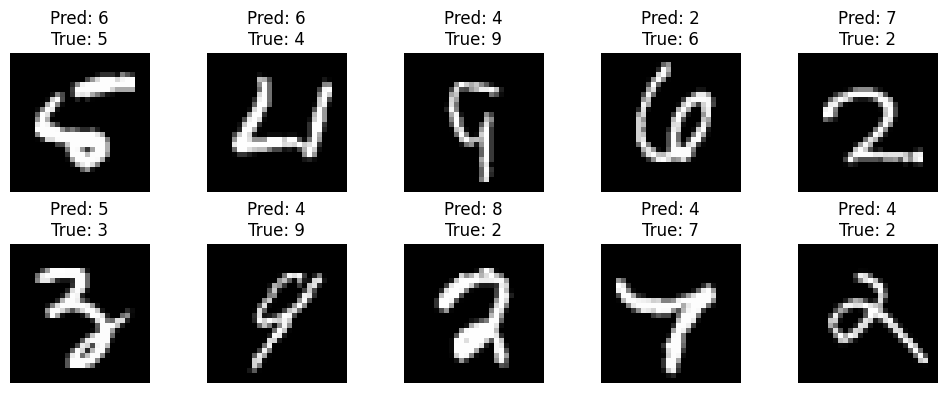

In [ ]:

_, _, _, _, _, a3_test = feed_forward_cache(X_test)

# Compute predictions and the true labels
predictions = np.argmax(a3_test, axis=0)
true_labels = np.argmax(Y_test, axis=0)

# Calculate the accuracy on the test dataset
accuracy = np.mean(predictions == true_labels)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Find the indices of misclassified images
misclassified_idx = np.where(predictions != true_labels)[0]
print("Number of misclassified samples:", len(misclassified_idx))

# Plot some of the misclassified images
num_to_plot = min(10, len(misclassified_idx))
plt.figure(figsize=(10, 4))
for i in range(num_to_plot):
    idx = misclassified_idx[i]
    # Retrieve the image from the original normalized test set.
    # test_images_norm has shape (10000, 28, 28) corresponding to the original ordering.
    img = test_images_norm[idx]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {predictions[idx]}\nTrue: {true_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()